In [1]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)

# deep_iSITH is being used here, not deep_sith
from sith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.DoubleTensor'>


In [3]:
sig_lets = ["A","B","C","D","E","F","G","H",]
signals = ttype([[0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
                [0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]]
               ).view(8, 1, 1, -1)
#signals = ms
key2id = {k:i for i, k in enumerate(sig_lets)}

print(key2id)
print(signals.shape)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}
torch.Size([8, 1, 1, 34])


In [4]:
def train_model(model, 
                signals,
                optimizer,
                loss_func,
                train_dur=2.0,
                test_durs=[1.5, 2.0, 2.5],
                epochs=1500,
                loss_buffer_size=50,
                testing_every=30):
    loss_track = {"loss":[],
                  "epoch":[],
                  "acc":[],
                  "perf":[]}
    losses = []
    
    progress_bar = tqdm(range(int(epochs)), ncols=800)
    for e in progress_bar:
        
       
        perm = torch.arange(signals.shape[0]).type(torch.cuda.LongTensor)
        
        # Zero the gradient between each batch
        model.zero_grad()
        
        
        # Present an entire batch to the model
        out = model(signals[perm])
        # Measure loss via CrossEntropyLoss
        loss = loss_func(out[:, -1], 
                         perm)
            
        # Adjust Weights
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        if len(losses) > loss_buffer_size:
            losses = losses[1:]
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['loss'].append(np.mean(losses))
        loss_track['epoch'].append(e)
        
        # calculate model accuracy:
        if ((e)%testing_every == 0) & (e != 0):
            model.eval()
            perf = test_model(model, signals)
            model.train()
            loss_track['perf'].append(perf)
        if e > testing_every:
            # Update progress_bar
            s = "{}: Loss: {:.6f}, Acc:{:.4f}"
            format_list = [e, loss_track['loss'][-1]] + [perf]            
            s = s.format(*format_list)
            progress_bar.set_description(s)
            if loss_track['perf'][-1] == 1.0:
                break
    return loss_track

def test_model(model, signals):
    # Test the Model
    out = model(signals)
    perf = (torch.argmax(out[:, -1, :], dim=-1) ==  torch.arange(signals.shape[0]).cuda()).sum().item() / signals.shape[0]
    
    return perf

# Setup Classifier type model

In [5]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

# TEST layers for correct taustars/parameters/cvalues
These dictionaries will not be used later. 

In [6]:
sith_params2 = {"in_features":1, 
                "tau_min":1, "tau_max":20.0, 'buff_max':40,
                "k":50,
                "ntau":5, 'g':0,  
                "ttype":ttype, 
                "hidden_size":10, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":200.0,  'buff_max':240,
                "k":50,
                "ntau":5, 'g':0, 
                "ttype":ttype, 
                "hidden_size":20, "act_func":nn.ReLU()}
layer_params = [sith_params2, sith_params3]
model = DeepSITH_Classifier(out_features=signals.shape[0],
                            layer_params=layer_params, dropout=.0).cuda().double()
print(model)
for i, l in enumerate(model.hs.layers):
    print("Layer {}".format(i), l.sith.tau_star)
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)

DeepSITH_Classifier(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=5, tau_min=1, tau_max=20.0, buff_max=40, dt=1, k=50, g=0)
        (linear): Sequential(
          (0): Linear(in_features=5, out_features=10, bias=True)
          (1): ReLU()
        )
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=5, tau_min=1, tau_max=200.0, buff_max=240, dt=1, k=50, g=0)
        (linear): Sequential(
          (0): Linear(in_features=50, out_features=20, bias=True)
          (1): ReLU()
        )
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
    )
  )
  (to_out): Linear(in_features=20, out_features=8, bias=True)
)
Layer 0 tensor([ 1.0000,  2.1147,  4.4721,  9.4574, 20.0000], dtype=torch.float64)
Layer 1 tensor([  1.0000,   3.7606,  14.1421,  53.1830, 200.0000], dtype=torch.float64)
Total Weights: 1278


# Visualize the taustar buffers
They must all completely empty or there will be edge effects

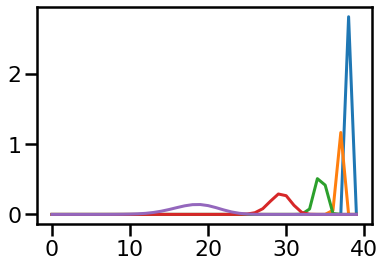

In [7]:
plt.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T);

# Training and testing

In [9]:
# You likely don't need this to be this long, but just in case.
epochs = 1000

# Just for visualizing average loss through time. 
loss_buffer_size = 100

In [10]:
loss_func = torch.nn.CrossEntropyLoss()

# A note about the size of the samples
The size of the input signals is (8, 1, 1, 34). This is because the model takes in data of size (batch, MAGIC, features, sequence). The second "magic" dimention will always be 1 in order for this to quickly calculate the output of the SITH layer. 

In [13]:
sith_params2 = {"in_features":1, 
                "tau_min":.1, "tau_max":20.0, 'buff_max':40,
                "k":50,
                "ntau":10, 'g':0,  
                "ttype":ttype, 
                "hidden_size":10, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":.1, "tau_max":200.0,  'buff_max':240,
                "k":50,
                "ntau":10, 'g':0, 
                "ttype":ttype, 
                "hidden_size":20, "act_func":nn.ReLU()}
layer_params = [sith_params2, sith_params3]

model = DeepSITH_Classifier(out_features=signals.shape[0],
                            layer_params=layer_params, 
                            
                            dropout=0.).cuda().double()
optimizer = torch.optim.Adam(model.parameters())
perf = train_model(model, signals, optimizer, loss_func,
                   epochs=epochs, 
                   loss_buffer_size=loss_buffer_size)


In [ ]:
with open('filename.dill', 'wb') as handle:
    pickle.dump(perf, handle, protocol=pickle.HIGHEST_PROTOCOL)

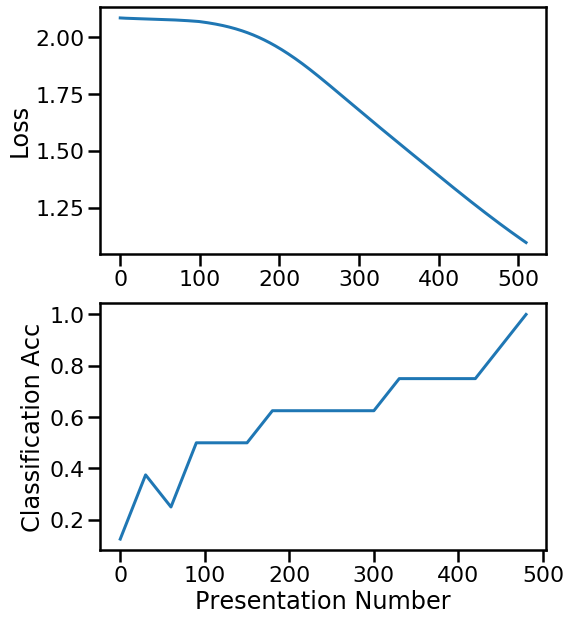

In [15]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1)
ax.plot(perf['loss'])
ax.set_ylabel("Loss")
#ax.set_xlabel("Presentation Number")

ax = fig.add_subplot(2,1,2)
dat = pd.DataFrame(perf['perf'])
ax.plot(np.arange(dat.shape[0])*30, dat)
ax.set_ylabel("Classification Acc")
ax.set_xlabel("Presentation Number")
()
plt.savefig("DeepSith_training_H8")